In [1]:
import pandas as pd
import ast

import torch
import torch.nn.functional as F

from torch_geometric.data import Data, HeteroData

import wandb

In [2]:
def convert_edges(edges, mapping_1, mapping_2):
    edges_ = torch.empty((2, len(edges)), dtype=torch.long)
    for i, row in edges.iterrows():
        try:
            edges_[0][i] = mapping_1[row.iloc[0]]
            edges_[1][i] = mapping_2[row.iloc[1]]
        except:
            edges_[0][i] = -1
            edges_[1][i] = -1

    # Remove invalid edges
    edges_ = edges_[:, edges_[0] != -1]

    return edges_


def expand_columns(df, cols):
    num_cols_ = {}
    for col in cols:
        df[col] = df[col].apply(ast.literal_eval)

        num_cols = len(df[col][0])
        num_cols_[col] = num_cols

        cols = pd.DataFrame(
            df[col].tolist(), columns=[f"{col}_{i}" for i in range(num_cols)]
        )

        df = pd.concat([df, cols], axis=1)

        df = df.drop(columns=[col])

    return df, num_cols_


def create_hetero_data(path):
    movies = pd.read_csv(f"{path}/movies.csv")
    actors = pd.read_csv(f"{path}/actors.csv")
    directors = pd.read_csv(f"{path}/directors.csv")
    writers = pd.read_csv(f"{path}/writers.csv")

    movie_actor_ = pd.read_csv(f"{path}/movie_actor.csv")
    movie_director_ = pd.read_csv(f"{path}/movie_director.csv")
    movie_writer_ = pd.read_csv(f"{path}/movie_writer.csv")

    actor_actor_ = pd.read_csv(f"{path}/actor_actor.csv")
    actor_director_ = pd.read_csv(f"{path}/actor_director.csv")
    actor_writer_ = pd.read_csv(f"{path}/actor_writer.csv")

    director_director_ = pd.read_csv(f"{path}/director_director.csv")
    director_writer_ = pd.read_csv(f"{path}/director_writer.csv")

    writer_writer_ = pd.read_csv(f"{path}/writer_writer.csv")

    movies, num_cols = expand_columns(movies, ["genres"])

    movies["release_date"] = pd.to_datetime(movies["release_date"])
    first_date = movies["release_date"].min()
    movies["release_date"] = (movies["release_date"] - first_date).dt.days

    # print(movies)

    movies_id = movies["id"].tolist()
    actors_id = actors["id"].tolist()
    directors_id = directors["id"].tolist()
    writers_id = writers["id"].tolist()

    movies_map = dict(zip(movies_id, range(len(movies_id))))
    actors_map = dict(zip(actors_id, range(len(actors_id))))
    directors_map = dict(zip(directors_id, range(len(directors_id))))
    writers_map = dict(zip(writers_id, range(len(writers_id))))

    data = HeteroData()

    data["movie"].ids = torch.tensor(movies_id, dtype=torch.long)
    data["movie"].x = torch.tensor(
        movies[
            [
                "release_date",
                "budget",
                "revenue",
                "vote_average",
                "vote_count",
                "popularity",
            ]
            + [f"genres_{i}" for i in range(num_cols["genres"])]
        ].values.tolist(),
        dtype=torch.float,
    )

    # normalize
    data["movie"].x[:, :6] = F.normalize(data["movie"].x[:, :6], dim=0)
    data["movie"].x[:, 6:] = F.normalize(data["movie"].x[:, 6:], dim=1)

    data["actor"].ids = torch.tensor(actors_id, dtype=torch.long)
    data["actor"].x = torch.ones((len(actors_id), 1), dtype=torch.float)
    data["actor"].y = torch.tensor(
        actors[["popularity"]].values.tolist(), dtype=torch.float
    )

    data["actor"].y = torch.log(data["actor"].y)

    data["director"].ids = torch.tensor(directors_id, dtype=torch.long)
    data["director"].x = torch.tensor(
        directors[["popularity"]].values.tolist(), dtype=torch.float
    )

    data["writer"].ids = torch.tensor(writers_id, dtype=torch.long)
    data["writer"].x = torch.tensor(
        writers[["popularity"]].values.tolist(), dtype=torch.float
    )

    data["movie", "played_by", "actor"].edge_index = convert_edges(
        movie_actor_, movies_map, actors_map
    )

    data["movie", "directed_by", "director"].edge_index = convert_edges(
        movie_director_, movies_map, directors_map
    )
    data["movie", "written_by", "writer"].edge_index = convert_edges(
        movie_writer_, movies_map, writers_map
    )

    data["actor", "same_page", "actor"].edge_index = convert_edges(
        actor_actor_, actors_map, actors_map
    )
    data["actor", "same_page", "director"].edge_index = convert_edges(
        actor_director_, actors_map, directors_map
    )
    data["actor", "same_page", "writer"].edge_index = convert_edges(
        actor_writer_, actors_map, writers_map
    )

    data["director", "same_page", "director"].edge_index = convert_edges(
        director_director_, directors_map, directors_map
    )
    data["director", "same_page", "writer"].edge_index = convert_edges(
        director_writer_, directors_map, writers_map
    )

    data["writer", "same_page", "writer"].edge_index = convert_edges(
        writer_writer_, writers_map, writers_map
    )

    return data

In [3]:
data = create_hetero_data("dataset")

In [4]:
print(data)
print(data["movie"].x[12])
# print(data.has_isolated_nodes())
# print(data.has_self_loops())
# print(data.is_undirected())

HeteroData(
  movie={
    ids=[13337],
    x=[13337, 25],
  },
  actor={
    ids=[54506],
    x=[54506, 1],
    y=[54506, 1],
  },
  director={
    ids=[9291],
    x=[9291, 1],
  },
  writer={
    ids=[11412],
    x=[11412, 1],
  },
  (movie, played_by, actor)={ edge_index=[2, 96751] },
  (movie, directed_by, director)={ edge_index=[2, 12357] },
  (movie, written_by, writer)={ edge_index=[2, 14432] },
  (actor, same_page, actor)={ edge_index=[2, 119604] },
  (actor, same_page, director)={ edge_index=[2, 33168] },
  (actor, same_page, writer)={ edge_index=[2, 30598] },
  (director, same_page, director)={ edge_index=[2, 7394] },
  (director, same_page, writer)={ edge_index=[2, 8201] },
  (writer, same_page, writer)={ edge_index=[2, 7395] }
)
tensor([8.5982e-03, 5.8821e-04, 0.0000e+00, 7.9674e-03, 2.1253e-04, 5.7698e-04,
        7.0711e-01, 0.0000e+00, 7.0711e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.

In [5]:
import torch_geometric.transforms as T

data = T.ToUndirected()(data)
data = T.AddSelfLoops()(data)

In [6]:
from torch_geometric.nn import SAGEConv, GATConv, CGConv, Linear, to_hetero

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        self.conv2 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        self.lin1 = Linear(-1, hidden_channels)
        self.lin2 = Linear(-1, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index) 
        x = x.relu()
        x = self.conv2(x, edge_index) 
        x = x.relu()
        x = self.lin2(x)
        # x = x.relu()
        # x = self.lin2(x)
        return x

data.to(device)

model = GNN(hidden_channels=128, out_channels=1)
model = to_hetero(model, data.metadata(), aggr='mean').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

random_indices = torch.randperm(data['actor'].num_nodes)
train_indices = random_indices[:int(data['actor'].num_nodes * 0.8)]
test_indices = random_indices[int(data['actor'].num_nodes * 0.8):]

wandb.init(project="movie-actor")

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    loss = F.mse_loss(out["actor"][train_indices], data["actor"].y[train_indices])
    loss.backward()
    optimizer.step()
    return float(loss)

from sklearn.metrics import r2_score

for epoch in range(1, 1001):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    wandb.log({"training-loss": loss})
    
    if epoch % 10 == 0:
        model.eval()
        out = model(data.x_dict, data.edge_index_dict)
        
        y_pred = out["actor"][train_indices].detach().cpu().numpy()
        y_true = data["actor"].y[train_indices].detach().cpu().numpy()
        score = r2_score(y_true, y_pred)
        wandb.log({"train-score": score})
        
        y_pred = out["actor"][test_indices].detach().cpu().numpy()
        y_true = data["actor"].y[test_indices].detach().cpu().numpy()
        score = r2_score(y_true, y_pred)
        wandb.log({"test-score": score})
        
        test_loss = F.mse_loss(out["actor"][test_indices], data["actor"].y[test_indices])
        wandb.log({"test-loss": test_loss})
        
        print(f"Epoch: {epoch:03d}, loss: {test_loss:.4f}, score: {score:.4f}")
        
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: damix48. Use `wandb login --relogin` to force relogin


Epoch: 001, Loss: 3.4812
Epoch: 002, Loss: 3.1249
Epoch: 003, Loss: 2.8068
Epoch: 004, Loss: 2.5187
Epoch: 005, Loss: 2.2816
Epoch: 006, Loss: 2.1131
Epoch: 007, Loss: 2.0205
Epoch: 008, Loss: 1.9892
Epoch: 009, Loss: 1.9821
Epoch: 010, Loss: 1.9678
Epoch: 010, loss: 1.9351, score: -0.1221
Epoch: 011, Loss: 1.9340
Epoch: 012, Loss: 1.8823
Epoch: 013, Loss: 1.8186
Epoch: 014, Loss: 1.7489
Epoch: 015, Loss: 1.6803
Epoch: 016, Loss: 1.6189
Epoch: 017, Loss: 1.5675
Epoch: 018, Loss: 1.5251
Epoch: 019, Loss: 1.4897
Epoch: 020, Loss: 1.4588
Epoch: 020, loss: 1.4301, score: 0.1708
Epoch: 021, Loss: 1.4301
Epoch: 022, Loss: 1.4055
Epoch: 023, Loss: 1.3916
Epoch: 024, Loss: 1.3727
Epoch: 025, Loss: 1.3672
Epoch: 026, Loss: 1.3630
Epoch: 027, Loss: 1.3610
Epoch: 028, Loss: 1.3636
Epoch: 029, Loss: 1.3586
Epoch: 030, Loss: 1.3574
Epoch: 030, loss: 1.3496, score: 0.2174
Epoch: 031, Loss: 1.3478
Epoch: 032, Loss: 1.3399
Epoch: 033, Loss: 1.3285
Epoch: 034, Loss: 1.3182
Epoch: 035, Loss: 1.3081
Epoc

test-loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test-score,▁▅▆▇▇▇▇▇████████████████████████████████
train-score,▁▅▆▆▇▇▇▇▇▇▇█████████████████████████████
training-loss,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test-loss,0.96279
test-score,0.44174
train-score,0.46059
training-loss,0.93555


Text(0.5, 1.0, 'Predicted')

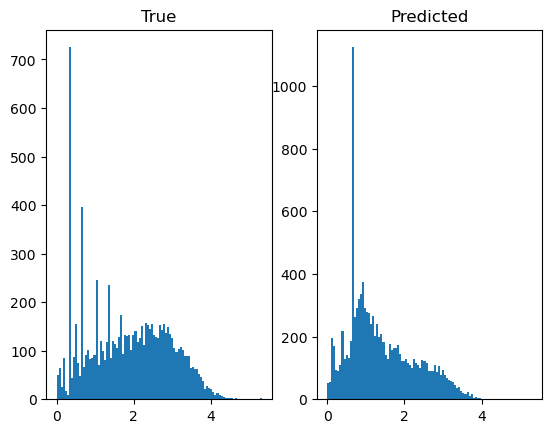

In [7]:
import matplotlib.pyplot as plt

# plt.scatter(y_true, y_pred)
# 2 histograms same figure

fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.hist(y_true, bins=100, range=(0, y_true.max()))
ax1.set_title('True')

ax2 = fig.add_subplot(122)
ax2.hist(y_pred, bins=100, range=(0, y_true.max()))
ax2.set_title('Predicted')

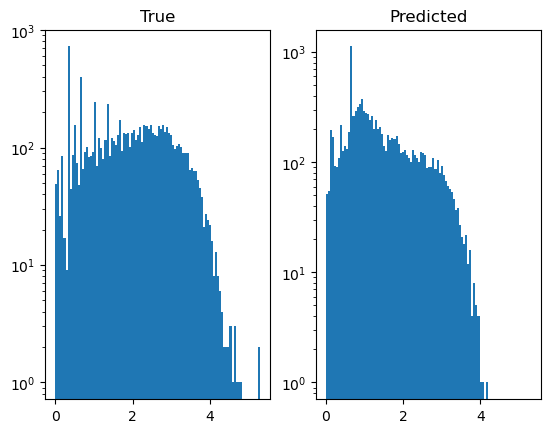

In [8]:
import numpy as np
fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.hist(y_true, bins=100, range=(0, y_true.max()))
ax1.set_title('True')

plt.yscale('log')

ax2 = fig.add_subplot(122)
ax2.hist(y_pred, bins=100, range=(0, y_true.max()))
ax2.set_title('Predicted')

plt.yscale('log')
